In [1]:
import pandas as pd
import numpy as np

Imports from utils

In [2]:
from dataprep import generate_samples, reduce_dimensions_sparse_tf_idf, feature_extractor, plot_lower_triangular_corr_matrix, prediction


Data Import

In [3]:
train_set = pd.read_csv('train.txt', sep=' ', header=None)
test_set = pd.read_csv('test.txt', sep=' ', header=None)

In [4]:
train_set = train_set.rename(columns={0 : 'source_id', 1:'target_id', 2: 'Link'})
test_set = test_set.rename(columns={0:'source_id', 1:'target_id'})

In [5]:
node_features = pd.read_csv('node_information.csv', header=None)


In [6]:
node_features = node_features.rename(columns={0 : 'node_id'})

In [7]:
sorted_nodes = list(node_features['node_id'].unique())

In [8]:
sorted_nodes.sort()

Node Mapping to have consistent and ordered node_id (Need it for GNNs)

In [9]:
node_mapping = {node_id: i for i, node_id in enumerate(sorted_nodes)}

In [10]:
# Step 2: Apply the mapping
node_features['node_id'] = node_features['node_id'].map(node_mapping)
train_set['source_id'] = train_set['source_id'].map(node_mapping)
train_set['target_id'] = train_set['target_id'].map(node_mapping)

In [11]:
test_set['source_id'] = test_set['source_id'].map(node_mapping)
test_set['target_id'] = test_set['target_id'].map(node_mapping)

In [12]:
test_set.columns

Index(['source_id', 'target_id'], dtype='object')

Sanity check for all nodes to be present in node_info

In [13]:
set_nodes_train = set(pd.unique(pd.concat([train_set['source_id'],train_set['target_id']])))
set_nodes_test = set(pd.unique(pd.concat([test_set['source_id'],test_set['target_id']])))
all_nodes = set_nodes_train.union(set_nodes_test)
set_node_feats = set(pd.unique(node_features.node_id))

# Convert to sets for easier comparison
set_all_nodes = set(all_nodes)
set_node_ids_in_features = set_node_feats

# Find missing node IDs
missing_node_ids = set_all_nodes - set_node_ids_in_features

# Check if there are any missing node IDs
if missing_node_ids:
    print(f"Missing node IDs in features: {missing_node_ids}")
else:
    print("All nodes in the train and test datasets have corresponding features.")


All nodes in the train and test datasets have corresponding features.


Creating a Graph

In [14]:
import networkx as nx
from community import community_louvain
from sklearn.model_selection import train_test_split

# Assuming train_set and node_features are already defined and preprocessed as per your previous code.
training_values = train_set.values.tolist()
edges = [(node_pair[0], node_pair[1]) for node_pair in training_values if node_pair[2] == 1]
# Create the graph from the edge list
G = nx.Graph()
G = G.to_undirected()

G.add_nodes_from(all_nodes)
G.add_edges_from(edges)

Creating reduced node features

In [15]:
reduced_features = reduce_dimensions_sparse_tf_idf(node_features.drop(['node_id'],axis=1).values)

Epoch [1/100], Loss: 0.0064
Epoch [2/100], Loss: 0.0064
Epoch [3/100], Loss: 0.0063
Epoch [4/100], Loss: 0.0060
Epoch [5/100], Loss: 0.0058
Epoch [6/100], Loss: 0.0055
Epoch [7/100], Loss: 0.0052
Epoch [8/100], Loss: 0.0051
Epoch [9/100], Loss: 0.0050
Epoch [10/100], Loss: 0.0050
Epoch [11/100], Loss: 0.0049
Epoch [12/100], Loss: 0.0049
Epoch [13/100], Loss: 0.0049
Epoch [14/100], Loss: 0.0048
Epoch [15/100], Loss: 0.0049
Epoch [16/100], Loss: 0.0049
Epoch [17/100], Loss: 0.0048
Epoch [18/100], Loss: 0.0048
Epoch [19/100], Loss: 0.0048
Epoch [20/100], Loss: 0.0048
Epoch [21/100], Loss: 0.0047
Epoch [22/100], Loss: 0.0047
Epoch [23/100], Loss: 0.0047
Epoch [24/100], Loss: 0.0047
Epoch [25/100], Loss: 0.0047
Epoch [26/100], Loss: 0.0047
Epoch [27/100], Loss: 0.0047
Epoch [28/100], Loss: 0.0047
Epoch [29/100], Loss: 0.0047
Epoch [30/100], Loss: 0.0046
Epoch [31/100], Loss: 0.0046
Epoch [32/100], Loss: 0.0046
Epoch [33/100], Loss: 0.0046
Epoch [34/100], Loss: 0.0046
Epoch [35/100], Loss: 0

Generating Train and Val Sets

In [16]:
np.random.seed(0)

In [17]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

In [18]:
_, train_features_df = feature_extractor(G, residual_g, train_samples, reduced_features)
_, test_features_df = feature_extractor(G, residual_g, test_samples, reduced_features)

c:\Users\kingr\Downloads\M2 DSBA\MLNS\Kaggle\dataprep.py:385: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(train_graph, nodelist=nodelist)
100%|██████████| 8398/8398 [00:08<00:00, 1036.93it/s]
c:\Users\kingr\Downloads\M2 DSBA\MLNS\Kaggle\dataprep.py:385: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(train_graph, nodelist=nodelist)
100%|██████████| 2098/2098 [00:01<00:00, 1083.42it/s]


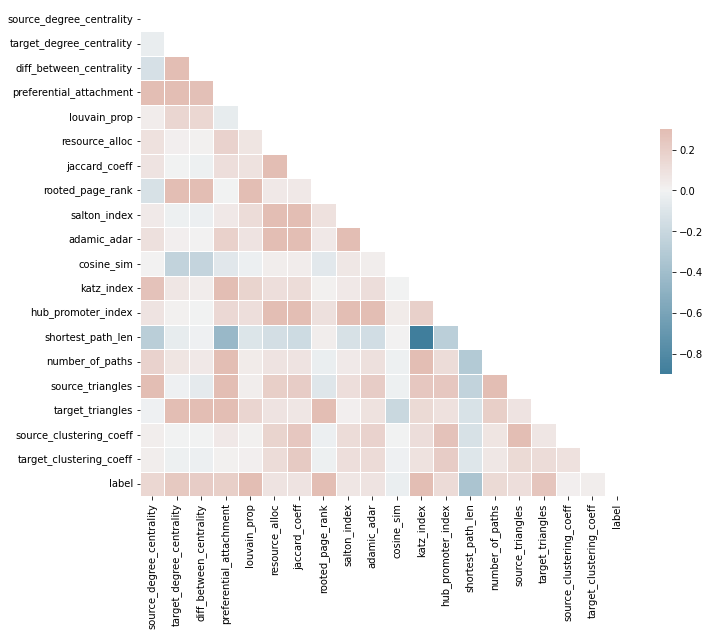

In [19]:
plot_lower_triangular_corr_matrix(train_features_df, train_labels)

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

def calculate_vif(df):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature in a DataFrame.
    
    Parameters:
    - df: Pandas DataFrame for which the VIF is computed.
    
    Returns:
    - VIF DataFrame: A DataFrame with two columns, 'Feature' and 'VIF', indicating the VIF for each feature.
    """
    # Adding a constant to "mimic" the intercept
    df = df.drop(['source_node','target_node'],axis=1)
    
    X = add_constant(df)
    vifs = pd.DataFrame()
    vifs["Feature"] = X.columns
    vifs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vifs

In [21]:
calculate_vif(train_features_df)

,Feature,VIF
0,const,97.560295
1,source_degree_centrality,5.022669
2,target_degree_centrality,379.844865
3,diff_between_centrality,377.239685
4,preferential_attachment,1.929986
5,louvain_prop,2.647662
6,resource_alloc,328.099775
7,jaccard_coeff,5.630724
8,rooted_page_rank,3.083517
9,salton_index,2.016618


In [22]:
train_features_df = train_features_df.drop(['shortest_path_len'],axis=1 )
test_features_df = test_features_df.drop(['shortest_path_len'],axis=1 )

In [23]:
# Check for NaN values
nan_columns = train_features_df.columns[train_features_df.isna().any()].tolist()

# Check for Inf values
inf_columns = train_features_df.columns[train_features_df.replace([np.inf, -np.inf], np.nan).isna().any()].tolist()

# Combine and get unique column names that have either NaN or Inf values
columns_with_issues = list(set(nan_columns + inf_columns))

print(f"Columns with NaN or Inf values: {columns_with_issues}")

Columns with NaN or Inf values: []


In [24]:
import warnings

warnings.filterwarnings('ignore')


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

def evaluate_feature_subset(features, train_features_df, train_labels, test_features_df, test_labels, random_state=42):
    """
    Trains SVM, RF, LR, and XGB models on the given feature subset and calculates their AUC, TPR, and TNR.
    """
    # Initialize the models
    svm = SVC(probability=True, random_state=random_state)
    rf = RandomForestClassifier(random_state=random_state)
    lr = LogisticRegression(random_state=random_state)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)

    # Train and predict with each model
    results = {}
    for model_name, model in zip(['svm', 'rf', 'lr', 'xgb'], [svm, rf, lr, xgb]):
        model.fit(train_features_df[features], train_labels)
        preds = model.predict_proba(test_features_df[features])[:, 1]
        preds_class = np.round(preds)
        auc = roc_auc_score(test_labels, preds)
        tn, fp, fn, tp = confusion_matrix(test_labels, preds_class).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate (Recall)
        tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
        
        results[f'{model_name}_auc'] = auc
        results[f'tpr_{model_name}'] = tpr
        results[f'tnr_{model_name}'] = tnr

    return results

# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=[
    'selected_features', 'svm_auc', 'rf_auc', 'lr_auc', 'xgb_auc',
    'tpr_svm', 'tnr_svm', 'tpr_rf', 'tnr_rf', 'tpr_lr', 'tnr_lr', 'tpr_xgb', 'tnr_xgb'
])

# Set a random seed for feature selection
random.seed(42)

iterations = 100

# Initial setup
feature_names = train_features_df.drop(['source_node', 'target_node'],axis=1).columns.tolist()
best_auc = 0
best_features = None
results_list = []
# Perform the random search for feature subsets
for i in range(iterations):
    selected_features = random.sample(feature_names, random.randint(1, len(feature_names)))
    results = evaluate_feature_subset(selected_features, train_features_df, train_labels, test_features_df, test_labels)
    
    result_dict = {
        'selected_features': ', '.join(selected_features),
        **results
    }
    results_list.append(result_dict)

    # Print iteration results
    print(f"----Iteration {i+1}/{iterations} -----")
    print(f"Selected features: {selected_features}")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")


# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)




----Iteration 1/100 -----
Selected features: ['source_degree_centrality', 'salton_index', 'rooted_page_rank', 'preferential_attachment']
svm_auc: 0.8308
tpr_svm: 0.4271
tnr_svm: 0.9371
rf_auc: 0.6059
tpr_rf: 0.0724
tnr_rf: 0.9990
lr_auc: 0.8643
tpr_lr: 0.2745
tnr_lr: 0.9876
xgb_auc: 0.8495
tpr_xgb: 0.0667
tnr_xgb: 0.9990
----Iteration 2/100 -----
Selected features: ['preferential_attachment', 'diff_between_centrality', 'number_of_paths', 'source_degree_centrality', 'source_triangles']
svm_auc: 0.7646
tpr_svm: 0.4204
tnr_svm: 0.9371
rf_auc: 0.8041
tpr_rf: 0.7178
tnr_rf: 0.7560
lr_auc: 0.7715
tpr_lr: 0.4547
tnr_lr: 0.9371
xgb_auc: 0.8235
tpr_xgb: 0.7140
tnr_xgb: 0.7645
----Iteration 3/100 -----
Selected features: ['jaccard_coeff', 'rooted_page_rank', 'source_degree_centrality']
svm_auc: 0.8697
tpr_svm: 0.0934
tnr_svm: 0.9990
rf_auc: 0.5981
tpr_rf: 0.0648
tnr_rf: 1.0000
lr_auc: 0.8684
tpr_lr: 0.0276
tnr_lr: 1.0000
xgb_auc: 0.8427
tpr_xgb: 0.0667
tnr_xgb: 1.0000
----Iteration 4/100 -----
S

In [33]:
best_results = results_df[results_df['tpr_xgb']>0.8]

In [36]:
best_results['selected_features'].values

array(['diff_between_centrality, source_triangles, preferential_attachment, source_degree_centrality, cosine_sim, salton_index, source_clustering_coeff, target_degree_centrality',
       'number_of_paths, salton_index, target_degree_centrality'],
      dtype=object)

Common features with high TPR

In [42]:
selected_features_arrays = results_df[(results_df['tpr_rf']>=0.7) | (results_df['tpr_xgb']>=0.7)]['selected_features'].values

In [46]:
from collections import Counter
# Step 1 & 2: Split and flatten the list of features
all_features = [feature for features_str in selected_features_arrays for feature in features_str.split(', ')]

# Step 3: Count occurrences of each feature
feature_counts = Counter(all_features)

sorted_features_by_counts = feature_counts.most_common()
# Print feature counts
for feature, count in sorted_features_by_counts:
    print(f"{feature}: {count}")

preferential_attachment: 2
diff_between_centrality: 2
number_of_paths: 2
source_degree_centrality: 2
source_triangles: 2
salton_index: 2
target_degree_centrality: 2
cosine_sim: 1
source_clustering_coeff: 1


Common Features with high TNR

In [47]:
selected_features_arrays_tnr = results_df[(results_df['tnr_rf']>=0.8) | (results_df['tnr_xgb']>=0.8) | ((results_df['tnr_svm']>=0.8) | (results_df['tnr_lr']>=0.8))]['selected_features'].values

In [48]:
from collections import Counter
# Step 1 & 2: Split and flatten the list of features
all_features = [feature for features_str in selected_features_arrays_tnr for feature in features_str.split(', ')]

# Step 3: Count occurrences of each feature
feature_counts = Counter(all_features)

sorted_features_by_counts = feature_counts.most_common()
# Print feature counts
for feature, count in sorted_features_by_counts:
    print(f"{feature}: {count}")

rooted_page_rank: 62
salton_index: 61
preferential_attachment: 60
source_triangles: 59
hub_promoter_index: 59
jaccard_coeff: 58
target_triangles: 58
target_clustering_coeff: 57
louvain_prop: 55
target_degree_centrality: 55
source_degree_centrality: 54
number_of_paths: 54
source_clustering_coeff: 53
cosine_sim: 53
katz_index: 53
resource_alloc: 50
diff_between_centrality: 49
adamic_adar: 47


Common features with a balanced TPR and TNR

In [52]:
selected_feats_balance = results_df[(abs(results_df['tpr_xgb'] - results_df['tnr_xgb']) < 0.2) | (abs(results_df['tpr_rf'] - results_df['tnr_rf']) < 0.2) | (abs(results_df['tpr_lr'] - results_df['tnr_lr']) < 0.2) | (abs(results_df['tpr_svm'] - results_df['tnr_svm']) < 0.2)]['selected_features'].values

In [53]:
from collections import Counter
# Step 1 & 2: Split and flatten the list of features
all_features = [feature for features_str in selected_feats_balance for feature in features_str.split(', ')]

# Step 3: Count occurrences of each feature
feature_counts = Counter(all_features)

sorted_features_by_counts = feature_counts.most_common()
# Print feature counts
for feature, count in sorted_features_by_counts:
    print(f"{feature}: {count}")

cosine_sim: 6
number_of_paths: 5
preferential_attachment: 4
diff_between_centrality: 4
source_triangles: 4
salton_index: 4
source_degree_centrality: 3
target_triangles: 3
target_degree_centrality: 2
hub_promoter_index: 2
target_clustering_coeff: 2
jaccard_coeff: 2
source_clustering_coeff: 1
resource_alloc: 1
katz_index: 1


- Below are the features we chose to strike a good balance
- We included louvain because of the community structure in graph and its ability to predict no links 

In [ ]:
['diff_between_centrality', 'source_triangles', 'preferential_attachment', 'source_degree_centrality', 'cosine_sim', 'salton_index', 'source_clustering_coeff', 'target_degree_centrality']